In [1]:
%cd '../HOTS'
from Tools import netparam, knn, JensenShannon, BattachaNorm, fit_jitter
import numpy as np
import matplotlib.pyplot as plt
import pickle
from os.path import isfile
import torch

/home/antoine/homhots/HOTS/HOTS


In [2]:
def printfig(fig, name):
    dpi_exp = None
    bbox = 'tight'
    path = '../../paper/5f22d412742c360001c92b46/fig/'
    #path = '../../GrimaldiEtAl2020HOTS_clone_laurent/fig'
    fig.savefig(path+name, dpi = dpi_exp, bbox_inches=bbox, transparent=True)

# Testing on the full dataset

In [20]:
sigma = None
pooling = False
homeinv = False
jitonic = [None,None] #[temporal, spatial]
jitter = False
R = 2
tau = 5
nbclust = [4,8,16]
filt = 2

timestr = '2021-03-29'
record_path = '../Records/EXP_03_NMNIST/'
dataset = 'nmnist'
nb_train = 60000
nb_test = 10000
ds = 1

nb_test = nb_test//ds
nb_train = nb_train//ds
print(f'training set size: {nb_train} - testing set: {nb_test}')

kNN = 12
verbose=False

training set size: 60000 - testing set: 10000


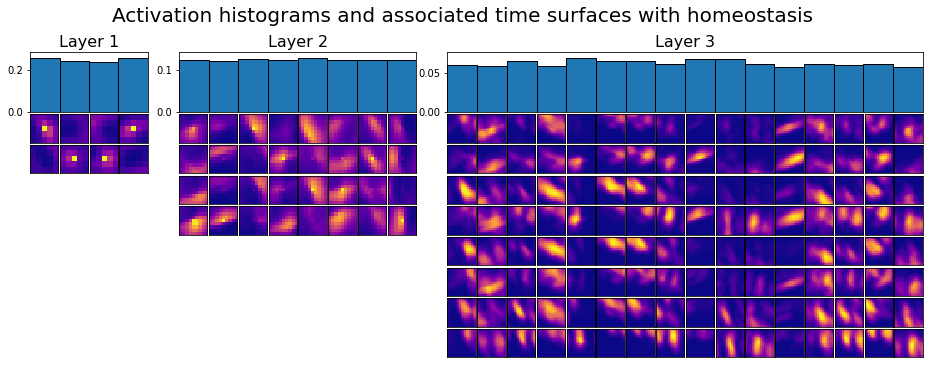

----------Averaged histograms----------
Performances for homhots with Euclidian distance: 44.0%
Performances for homhots with Bhattacharyya distance: 45.800000000000004%
Performances for homhots with Jensen-Shannon distance: 45.9%
---------Per sample histograms---------
Performances for homhots with  k-NN (k=12): 87.7%


In [23]:
for name in ['homhots']:#, 'homhots']:
    f_name = f'{record_path}{timestr}_results_fullset_histo_{name}.pkl'
    hotshom, homeotest = netparam(name, filt, tau, nbclust, sigma, homeinv, jitter, timestr, dataset, R)#, nb_learn=50)
    fig = hotshom.plotlayer()
    if isfile(f_name):
        with open(f_name, 'rb') as file:
            scores = pickle.load(file)
    else:
        trainhistomap = hotshom.running(homeotest=homeotest, nb_digit = nb_train, outstyle='histo', dataset=dataset, verbose=verbose)
        testhistomap = hotshom.running(homeotest = homeotest, train=False, nb_digit=nb_test, jitonic=jitonic, dataset=dataset, verbose=verbose)
        JS_kNN_score = knn(trainhistomap,testhistomap, k = kNN, weights = 'distance', metric = JensenShannon)
        kNN_score = knn(trainhistomap,testhistomap, k = kNN, weights = 'distance')
        
        trainhistomapav = hotshom.running(homeotest=homeotest, nb_digit = nb_train, outstyle='histav', dataset=dataset, verbose=verbose)
        trainhistomapav2 = []
        for i in range(trainhistomapav.shape[0]):
            trainhistomapav2.append([i,trainhistomapav[i,:]])
        JS_score = knn(trainhistomapav2,testhistomap, k = 1, weights = 'uniform', metric = JensenShannon)
        BA_score = knn(trainhistomapav2,testhistomap, k = 1, weights = 'uniform', metric = BattachaNorm)
        EU_score = knn(trainhistomapav2,testhistomap, k = 1, weights = 'uniform')

        scores = [EU_score, BA_score, JS_score, kNN_score, JS_kNN_score]
        with open(f_name, 'wb') as file:
            pickle.dump(scores, file, pickle.HIGHEST_PROTOCOL)
        
    print('----------Averaged histograms----------')
    print(f'Performances for {name} with Euclidian distance: {np.round(scores[0],3)*100}%')
    print(f'Performances for {name} with Bhattacharyya distance: {np.round(scores[1],3)*100}%')
    print(f'Performances for {name} with Jensen-Shannon distance: {np.round(scores[2],3)*100}%')
    print('---------Per sample histograms---------')
    print(f'Performances for {name} with  k-NN (k={kNN}): {np.round(scores[3],3)*100}%')
    #print(f'Performances for {name} with  k-NN using Jensen-Shannon as a metric (k={kNN}): {np.round(scores[4],3)*100}%')

In [24]:
printfig(fig, 'layerwiz.pdf')

# Testing on different folds

- trainset is composed of all avaible samples: 60 000 digits
- testset is divided into 10 folds of 1000 samples each

In [5]:
nb_test = 10000
ds = 10
nb_test = nb_test//ds
print(f'training set size: {nb_train} - testing set: {nb_test}')

training set size: 60000 - testing set: 1000


In [6]:
verbose = False
for name in ['hots','homhots']:
    f_name = f'{record_path}{timestr}_results_kfolds_{nb_test}_histo_{name}.pkl'
    hotshom, homeotest = netparam(name, filt, tau, nbclust, sigma, homeinv, jitter, timestr, dataset, R)#, nb_learn=50)
    trainhistomap = hotshom.running(homeotest=homeotest, nb_digit=nb_train, outstyle='histo', verbose = verbose)
    if isfile(f_name):
        with open(f_name, 'rb') as file:
            scores = pickle.load(file)
        print('results loaded')
    else:
        scores = []
        for i in range(ds):
            testhistomap = hotshom.running(homeotest=homeotest, train=False, nb_digit=nb_test, jitonic=jitonic, kfold = ds, kfold_ind=i, verbose=verbose)
            kNN_score = knn(trainhistomap,testhistomap, k = kNN, weights = 'distance')
            scores.append(kNN_score)
        with open(f_name, 'wb') as file:
            pickle.dump(scores, file, pickle.HIGHEST_PROTOCOL)
    print(f'Mean accuracy for {name} = {np.round(np.mean(scores),3)*100}% - std = {np.round(np.std(scores),3)*100}')

results loaded
Mean accuracy for hots = 87.0% - std = 1.0
results loaded
Mean accuracy for homhots = 87.9% - std = 1.4000000000000001


# Online classification

In [5]:
%cd '../HOTS'
from Tools import fit_data, predict_data, classification_numbevents, classification_timescale
from os.path import isfile
import matplotlib.pyplot as plt
import pickle
import numpy as np

nb_test = 10000
num_workers = 0
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 5 + 1
ds_ev = 1
tau_cla = 150e3

sigma = None
pooling = False
homeinv = False
jitonic = [None,None] #[temporal, spatial]
jitter = False
R = 2
tau = 5
nbclust = [4,8,16]
filt = 2

timestr = '2021-03-29'
record_path = '../Records/EXP_03_NMNIST/'
dataset = 'nmnist'
nb_train = 60000
nb_test = 10000
nb_classes = 10

kNN = 12
verbose=False

/home/antoine/homhots/HOTS/HOTS


## As a function of the number of events
### Make predition for every event

To get the likelihood values given by the LR, you may need to run:

- ../dev/2021-05-22-homhots_LR.py script

/home/antoine/homhots/HOTS/HOTS/Tools.py:565: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)
/home/antoine/homhots/HOTS/HOTS/Tools.py:574: RuntimeWarning: Mean of empty slice
  zeroclassif = np.sum(np.isnan(np.nanmean(matscor,axis=1)))


214 samples where not classified
---------------------------------------------for raw---------------------------------------------
Mean accuracy for raw: 42.1%
Last event accuracy for raw: 35.6%
Accuracy with argmax over the probabilities of a sample for raw: 44.7%
Accuracy when taking the highest counts of classified events for a sample for raw: 44.6%
Accuracy when taking the highest counts of the last third of classified events for a sample for raw: 41.9%
-----------------------------------------------------------------------------------------------------


/home/antoine/homhots/HOTS/HOTS/Tools.py:565: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


0 samples where not classified
---------------------------------------------for homhots---------------------------------------------
Mean accuracy for homhots: 93.10000000000001%
Last event accuracy for homhots: 93.60000000000001%
Accuracy with argmax over the probabilities of a sample for homhots: 94.8%
Accuracy when taking the highest counts of classified events for a sample for homhots: 95.1%
Accuracy when taking the highest counts of the last third of classified events for a sample for homhots: 95.5%
-----------------------------------------------------------------------------------------------------


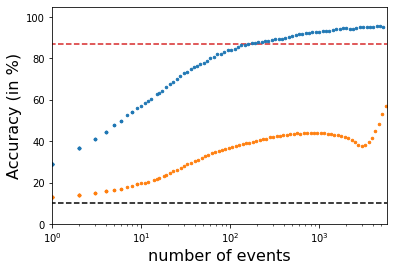

In [5]:
thres = None
colorz = ['#ff7f0e','#1f77b4','#d62728']
legend_list = ['original HOTS', 'MLR with raw inputs','online HOTS']
namelist = ['raw', 'homhots']
fig_onl, ax_onl = plt.subplots()
for namnum, name in enumerate(namelist):
    f_name = f'{record_path}{timestr}_LR_results_{name}_{nbclust}_{nb_train}_{nb_test}_{ds_ev}.pkl'
    with open(f_name, 'rb') as file:
        likelihood, true_target = pickle.load(file)
    meanac, onlinac, lastac, maxprobac, maxevac, maxevac_end, truepos, falsepos, lastev = classification_numbevents(likelihood, true_target, thres, nb_test, 1/nb_classes)
    print(45*'-'+f'for {name}'+45*'-')
    print(f'Mean accuracy for {name}: {np.round(meanac,3)*100}%')
    print(f'Last event accuracy for {name}: {np.round(lastac,3)*100}%')
    print(f'Accuracy with argmax over the probabilities of a sample for {name}: {np.round(maxprobac,3)*100}%')
    print(f'Accuracy when taking the highest counts of classified events for a sample for {name}: {np.round(maxevac,3)*100}%')
    print(f'Accuracy when taking the highest counts of the last third of classified events for a sample for {name}: {np.round(maxevac_end,3)*100}%')
    print(101*'-')
    sampling = (np.logspace(0,np.log10(lastev),100)).astype(int)
    ax_onl.semilogx(sampling[:-1],onlinac[sampling[:-1]]*100, '.', ms=5, color=colorz[namnum], label = legend_list[namnum+1]);
ax_onl.hlines(86.9,0,int(lastev), linestyles='dashed', color=colorz[2], label=legend_list[0])
ax_onl.hlines(1/nb_classes*100,0,int(lastev), linestyles='dashed', color='k', label='chance level')
ax_onl.axis([1,int(lastev),0,105]);
ax_onl.set_xlabel('Number of events', fontsize=16);
ax_onl.set_ylabel('Accuracy (in %)', fontsize=16);
#ax_onl.set_title('Accuracy evolution \n as a function of the number of events', fontsize=16);
#ax_onl.legend(fontsize=12, loc='lower right');

In [7]:
printfig(fig_onl, 'nmnist_online.pdf')

### Set threshold for the probability value to make prediction to 0.99

/home/antoine/homhots/HOTS/HOTS/Tools.py:565: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)
/home/antoine/homhots/HOTS/HOTS/Tools.py:574: RuntimeWarning: Mean of empty slice
  zeroclassif = np.sum(np.isnan(np.nanmean(matscor,axis=1)))


214 samples where not classified
---------------------------------------------for raw---------------------------------------------
Mean accuracy for raw: 48.8%
Last event accuracy for raw: 29.799999999999997%
Accuracy with argmax over the probabilities of a sample for raw: 44.7%
Accuracy when taking the highest counts of classified events for a sample for raw: 44.6%
Accuracy when taking the highest counts of the last third of classified events for a sample for raw: 42.0%
-----------------------------------------------------------------------------------------------------


/home/antoine/homhots/HOTS/HOTS/Tools.py:565: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


0 samples where not classified
---------------------------------------------for homhots---------------------------------------------
Mean accuracy for homhots: 95.39999999999999%
Last event accuracy for homhots: 90.8%
Accuracy with argmax over the probabilities of a sample for homhots: 94.8%
Accuracy when taking the highest counts of classified events for a sample for homhots: 95.1%
Accuracy when taking the highest counts of the last third of classified events for a sample for homhots: 95.3%
-----------------------------------------------------------------------------------------------------


Text(0, 0.5, 'Accuracy (in %)')

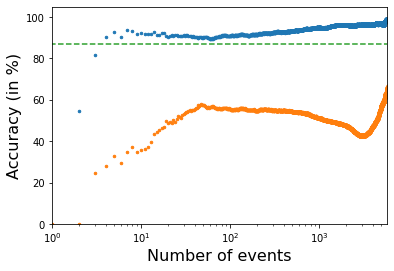

In [10]:
thres = 0.99
colorz = ['#ff7f0e', '#1f77b4', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
legend_list = ['original HOTS', 'MLR with raw inputs','online HOTS']
namelist = ['raw', 'homhots']
fig_onl, ax_onl = plt.subplots()
ax_onl.hlines(86.9,0,6000, linestyles='dashed', color=colorz[2], label=legend_list[0])
for namnum, name in enumerate(namelist):
    f_name = f'{record_path}{timestr}_LR_results_{name}_{nbclust}_{nb_train}_{nb_test}_{ds_ev}.pkl'
    with open(f_name, 'rb') as file:
        likelihood, true_target = pickle.load(file)
    meanac, onlinac, lastac, maxprobac, maxevac, maxevac_end, truepos, falsepos, lastev = classification_numbevents(likelihood, true_target, thres, nb_test, 1/nb_classes)
    print(45*'-'+f'for {name}'+45*'-')
    print(f'Mean accuracy for {name}: {np.round(meanac,3)*100}%')
    print(f'Last event accuracy for {name}: {np.round(lastac,3)*100}%')
    print(f'Accuracy with argmax over the probabilities of a sample for {name}: {np.round(maxprobac,3)*100}%')
    print(f'Accuracy when taking the highest counts of classified events for a sample for {name}: {np.round(maxevac,3)*100}%')
    print(f'Accuracy when taking the highest counts of the last third of classified events for a sample for {name}: {np.round(maxevac_end,3)*100}%')
    print(101*'-')
    ax_onl.semilogx(onlinac[:int(lastev)]*100, '.', ms=5, color=colorz[namnum], label = legend_list[namnum+1]);
ax_onl.axis([1,int(lastev),0,105]);
ax_onl.set_xlabel('Number of events', fontsize=16);
ax_onl.set_ylabel('Accuracy (in %)', fontsize=16);
#ax_onl.set_title('Accuracy evolution \n as a function of the number of events', fontsize=16);
#ax_onl.legend(fontsize=12, loc='lower right');

## As a function of time

/home/antoine/homhots/HOTS/HOTS/Tools.py:618: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


0 samples where not classified


/home/antoine/homhots/HOTS/HOTS/Tools.py:618: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


0 samples where not classified


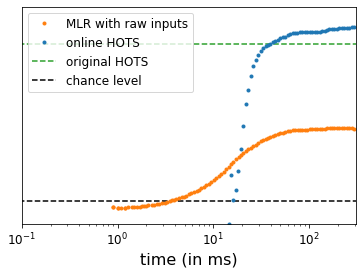

In [11]:
nb_classes = 10
timestep = 100
thres = None
namelist = ['raw','homhots']
legend_list = ['original HOTS','MLR with raw inputs', 'online HOTS']
colorz = ['#ff7f0e','#1f77b4','#d62728']
fig, ax = plt.subplots()
for namnum, name in enumerate(namelist):
    f_name = f'{record_path}{timestr}_LR_results_{name}_{nbclust}_{nb_train}_{nb_test}_{ds_ev}_timescale.pkl'
    with open(f_name, 'rb') as file:
        likelihood, true_target, timescale = pickle.load(file)
    meanac, onlinac, timesteps, lastime, truepos, falsepos = classification_timescale(likelihood, true_target, timescale, timestep, thres, nb_test, 1/nb_classes)
    sampling = (np.logspace(np.log10(np.where(np.round(timesteps)<1000)[0][-1]),np.log10(len(timesteps)),100)).astype(int)
    ax.semilogx(timesteps[sampling[:-1]]/1e3,onlinac[sampling[:-1]]*100, '.', label=legend_list[namnum+1], color = colorz[namnum])
ax.axis([1,lastime/1e3,0,105]);
ax.hlines(86.9,0,lastime/1e3, linestyles='dashed', color=colorz[2], label=legend_list[0])
ax.hlines(1+nb_classes,0,lastime/1e3, linestyles='dashed', color='k', label='chance level')
ax.set_xlabel('Time (in ms)', fontsize=16);
ax.set_yticks([])
plt.setp(ax.get_yticklabels(), fontsize=12)
plt.setp(ax.get_xticklabels(), fontsize=12)
ax.legend(fontsize=12, loc='upper left');

In [12]:
print(onlinac[[1000, 2000, 3000]])

[0.9273     0.9447     0.95146444]


In [13]:
printfig(fig, 'nmnist_online_time.pdf')

## As a function of the number of events when applying a spatial downsampling on the analog vector fed to the classification layer

/home/antoine/homhots/HOTS/HOTS/Tools.py:565: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


0 samples where not classified
---------------------------------------------for homhots---------------------------------------------
Mean accuracy for homhots: 93.30000000000001%
Last event accuracy for homhots: 93.4%
Accuracy with argmax over the probabilities of a sample for homhots: 94.89999999999999%
Accuracy when taking the highest counts of classified events for a sample for homhots: 95.0%
Accuracy when taking the highest counts of the last third of classified events for a sample for homhots: 95.39999999999999%
-----------------------------------------------------------------------------------------------------


/home/antoine/homhots/HOTS/HOTS/Tools.py:565: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


0 samples where not classified
---------------------------------------------for homhots---------------------------------------------
Mean accuracy for homhots: 92.9%
Last event accuracy for homhots: 93.30000000000001%
Accuracy with argmax over the probabilities of a sample for homhots: 94.69999999999999%
Accuracy when taking the highest counts of classified events for a sample for homhots: 95.39999999999999%
Accuracy when taking the highest counts of the last third of classified events for a sample for homhots: 95.19999999999999%
-----------------------------------------------------------------------------------------------------


/home/antoine/homhots/HOTS/HOTS/Tools.py:565: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


0 samples where not classified
---------------------------------------------for homhots---------------------------------------------
Mean accuracy for homhots: 89.9%
Last event accuracy for homhots: 88.3%
Accuracy with argmax over the probabilities of a sample for homhots: 91.60000000000001%
Accuracy when taking the highest counts of classified events for a sample for homhots: 93.0%
Accuracy when taking the highest counts of the last third of classified events for a sample for homhots: 91.2%
-----------------------------------------------------------------------------------------------------


/home/antoine/homhots/HOTS/HOTS/Tools.py:565: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


0 samples where not classified
---------------------------------------------for homhots---------------------------------------------
Mean accuracy for homhots: 83.6%
Last event accuracy for homhots: 83.5%
Accuracy with argmax over the probabilities of a sample for homhots: 85.7%
Accuracy when taking the highest counts of classified events for a sample for homhots: 87.8%
Accuracy when taking the highest counts of the last third of classified events for a sample for homhots: 84.8%
-----------------------------------------------------------------------------------------------------


/home/antoine/homhots/HOTS/HOTS/Tools.py:565: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


0 samples where not classified
---------------------------------------------for homhots---------------------------------------------
Mean accuracy for homhots: 77.9%
Last event accuracy for homhots: 78.3%
Accuracy with argmax over the probabilities of a sample for homhots: 74.9%
Accuracy when taking the highest counts of classified events for a sample for homhots: 84.7%
Accuracy when taking the highest counts of the last third of classified events for a sample for homhots: 82.39999999999999%
-----------------------------------------------------------------------------------------------------


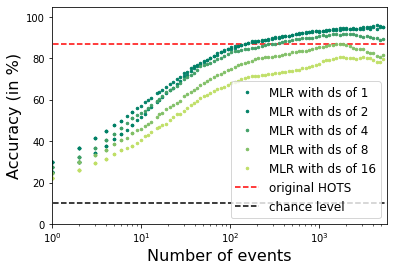

In [16]:
thres = None
name = 'homhots'
ds_spatial = [1,2,4,8,16]
#ds_spatial = [16,8,4,2,1]
colormap = plt.cm.get_cmap('summer', len(ds_spatial));
legend_list = [f'MLR with ds of {ds}' for ds in ds_spatial]
fig_onl, ax_onl = plt.subplots()
for idx, ds in enumerate(ds_spatial):
    f_name = f'{record_path}{timestr}_LR_results_{name}_{nbclust}_{nb_train}_{nb_test}_{ds_ev}_{ds}_timescale.pkl'
    if ds==1:
        f_name = f'{record_path}{timestr}_LR_results_{name}_{nbclust}_{nb_train}_{nb_test}_{ds_ev}_timescale.pkl'
    with open(f_name, 'rb') as file:
        likelihood, true_target, timescale = pickle.load(file)
    meanac, onlinac, lastac, maxprobac, maxevac, maxevac_end, truepos, falsepos, lastev = classification_numbevents(likelihood, true_target, thres, nb_test, 1/nb_classes)
    print(45*'-'+f'for {name}'+45*'-')
    print(f'Mean accuracy for {name}: {np.round(meanac,3)*100}%')
    print(f'Last event accuracy for {name}: {np.round(lastac,3)*100}%')
    print(f'Accuracy with argmax over the probabilities of a sample for {name}: {np.round(maxprobac,3)*100}%')
    print(f'Accuracy when taking the highest counts of classified events for a sample for {name}: {np.round(maxevac,3)*100}%')
    print(f'Accuracy when taking the highest counts of the last third of classified events for a sample for {name}: {np.round(maxevac_end,3)*100}%')
    print(101*'-')
    sampling = (np.logspace(0,np.log10(lastev),100)).astype(int)
    ax_onl.semilogx(sampling[:-1], onlinac[sampling[:-1]]*100, '.', ms=5, color=colormap(idx-1), label = legend_list[idx]);
ax_onl.hlines(86.9,0,int(lastev), linestyles='dashed', color='red', label='original HOTS')
ax_onl.hlines(1/nb_classes*100,0,int(lastev), linestyles='dashed', color='k', label='chance level')
ax_onl.axis([1,int(lastev),0,105]);
ax_onl.set_xlabel('Number of events', fontsize=16);
ax_onl.set_ylabel('Accuracy (in %)', fontsize=16);
#ax_onl.set_title('Accuracy evolution \n as a function of the number of events', fontsize=16);
ax_onl.legend(fontsize=12, loc='lower right');

In [18]:
printfig(fig_onl, 'nmnist_ds.pdf')

## AUC curves as a function of time 

### Done with a value of probability for each class taken at every timestep
To get the likelihood values given by the LR, you need to run:

- ../dev/2021-05-22-homhots_LR_timescale_nomean.py

AUC at 1ms (end of the recording): 0.546
AUC at 295ms (end of the recording): 0.719
AUC at 100ms (end of the first saccade): 0.757
AUC at 1ms (end of the recording): 0.848
AUC at 295ms (end of the recording): 0.997
AUC at 100ms (end of the first saccade): 0.997


<ipython-input-1-650a23137b5a>:19: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.axis([0,295,0.5,1.01]);


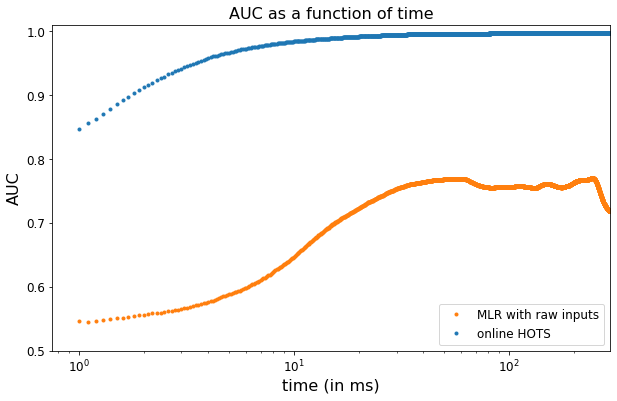

In [15]:
f_name = f'{record_path}{timestr}_LR_results_{nbclust}_{nb_train}_{nb_test}_1_AUC_nomean.pkl'
with open(f_name, 'rb') as file:
    results = pickle.load(file)

fig, ax = plt.subplots(figsize=(10,6))
namelist = ['raw', 'hots', 'homhots']
leg_list = ['MLR with raw inputs', 'online HOTS', 'online homeo HOTS']
colorz = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
#for namnum, name in enumerate(namelist):
ax.semilogx(results[0][0]/1e3, results[0][1], '.', label=leg_list[0], color=colorz[1])
print(f'AUC at 1ms (end of the recording): {np.round(results[0][1][0],3)}')
print(f'AUC at 295ms (end of the recording): {np.round(results[0][1][-1],3)}')
print(f'AUC at 100ms (end of the first saccade): {np.round(results[0][1][990],3)}')
ax.semilogx(results[0][0]/1e3, results[0][3], '.', label=leg_list[1], color = colorz[0])
print(f'AUC at 1ms (end of the recording): {np.round(results[0][3][0],3)}')
print(f'AUC at 295ms (end of the recording): {np.round(results[0][3][-1],3)}')
print(f'AUC at 100ms (end of the first saccade): {np.round(results[0][3][990],3)}')
    
ax.axis([0,295,0.5,1.01]);
ax.set_xlabel('time (in ms)', fontsize=16);
ax.set_ylabel('AUC', fontsize=16);
plt.setp(ax.get_yticklabels(), fontsize=12)
plt.setp(ax.get_xticklabels(), fontsize=12)
ax.set_title('AUC as a function of time', fontsize=16);
ax.legend(fontsize=12, loc='lower right');

# Robustness to jitter
To get the classification results as a function of jitter, you need to run:

- ../dev/2021-05-22-homhots_LR_jitter.py
- ../dev/2021-04-30-homhots_nmnist_jitter_0.py

In [26]:
%cd ../HOTS
from Tools import plotjitter
import pickle
import numpy as np
import matplotlib.pyplot as plt

timestr = '2021-03-29'
record_path = '../Records/EXP_03_NMNIST/'

/home/antoine/homhots/HOTS/HOTS


semi saturation level for online HOTS (ours): 407.38 ms
semi saturation level for HOTS with homeostasis: 100.0 ms
semi saturation level for original HOTS: 23.44 ms


[]

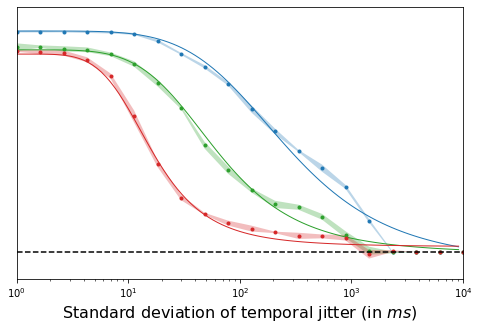

In [27]:
colorz = ['#2ca02c','#1f77b4','#d62728']

fitting = True
logscale = True

f_name = f'../Records/EXP_03_NMNIST/2021-03-29_LR_results_jitter_homhots_[4, 8, 16]_60000_1000_1_None_logscale.pkl'
with open(f_name, 'rb') as file:
    results_t, results_t_last, jit_t = pickle.load(file)
    
results_t = np.delete(results_t, [5,6,7,8,9], 0)
fig_t, ax_t = plt.subplots(1,1,figsize=(8,5))
param_T = [0.85, 2.5, 5, 0.1]
label = 'online HOTS (ours)'
n_epoch = 33
fig_t, ax_t, semisat_t = plotjitter(fig_t, ax_t, jit_t/1e3, results_t, param = param_T, color=colorz[1], label=label, n_epo=n_epoch, fitting = fitting, logscale=logscale)
if fitting:
    print(f'semi saturation level for {label}: {np.round(10**semisat_t,2)} ms')

f_name = f'../Records/EXP_03_NMNIST/2021-03-29_histo_results_jitter_homhots_[4, 8, 16]_60000_1000_1_None_logscale.pkl'
with open(f_name, 'rb') as file:
    score_t12, jit_t = pickle.load(file)

score_t12 = np.delete(score_t12, [5,6,7,8,9], 0)
label = 'HOTS with homeostasis'
param_T = [0.8, 1.7, 5, 0.1]
fig_t, ax_t, semisat_t = plotjitter(fig_t, ax_t, jit_t/1e3, score_t12, param = param_T, color=colorz[0], label=label, n_epo=n_epoch, fitting = fitting, logscale=logscale)
if fitting:
    print(f'semi saturation level for {label}: {np.round(10**semisat_t,2)} ms')

f_name = f'../Records/EXP_03_NMNIST/2021-03-29_histo_results_jitter_hots_[4, 8, 16]_60000_1000_1_None_logscale.pkl'
with open(f_name, 'rb') as file:
    score_t12, jit_t = pickle.load(file)

score_t12 = np.delete(score_t12, [0,7,8,9], 0)
label = 'original HOTS'
param_T = [0.8, 1.3, 5, 0.1]
fig_t, ax_t, semisat_t = plotjitter(fig_t, ax_t, jit_t/1e3, score_t12, param = param_T, color=colorz[2], label=label, n_epo=n_epoch, fitting = fitting, logscale=logscale)
if fitting:
    print(f'semi saturation level for {label}: {np.round(10**semisat_t,2)} ms')

chance_t = np.ones([len(jit_t)])*10
ax_t.plot(jit_t/1e3,chance_t, 'k--', label='chance level')
ax_t.axis([1,max(jit_t/1e3),0,100]);
ax_t.set_xlabel('Standard deviation of temporal jitter (in $ms$)', fontsize=16);
#ax_t.set_ylabel('accuracy (in %)', fontsize=16);
ax_t.set_yticks([])
#ax_t.set_title('Accuracy as a function of temporal jitter', fontsize=16);
#ax_t.legend(fontsize=12);

In [28]:
printfig(fig_t, 'temporal_jitter.pdf')

semi saturation level for online HOTS (ours): 2.94 pixels
semi saturation level for HOTS with homeostasis: 2.3 pixels
semi saturation level for original HOTS: 1.35 pixels


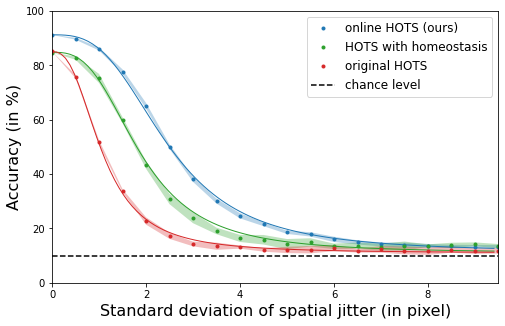

In [29]:
fitting = True
logscale = False

f_name = f'../Records/EXP_03_NMNIST/2021-03-29_LR_results_jitter_homhots_[4, 8, 16]_60000_1000_10_None.pkl'
std_jit_s = np.arange(0,10,0.5)

with open(f_name, 'rb') as file:
    results_s, results_t, results_s_last, results_t_last = pickle.load(file)

fig_s, ax_s = plt.subplots(1,1,figsize=(8,5))
param_S = [0.85, 2.5, 3, 0.1]
label = 'online HOTS (ours)'
n_epoch = 33
fig_s, ax_s, semisat_s = plotjitter(fig_s, ax_s, std_jit_s, results_s, param = param_S, color=colorz[1], label=label, n_epo=n_epoch, fitting = fitting, logscale=logscale)
if fitting:
    print(f'semi saturation level for {label}: {np.round(semisat_s,2)} pixels')

f_name = f'../Records/EXP_03_NMNIST/2021-03-29_results_jitter_1000_histo_homhots_std.pkl' 
with open(f_name, 'rb') as file:
    score_t1, score_t12, jit_t, score_s1, score_s12, jit_s = pickle.load(file)
    
results_s = np.delete(score_s12, [0,7,8,9], axis = 0)

label = 'HOTS with homeostasis'
param_S = [0.85, 2, 3, 0.1]
fig_s, ax_s, semisat_s = plotjitter(fig_s, ax_s, jit_s, results_s, param = param_S, color=colorz[0], label=label, n_epo=n_epoch, fitting = fitting, logscale=logscale)
if fitting:
    print(f'semi saturation level for {label}: {np.round(semisat_s,2)} pixels')

f_name = f'../Records/EXP_03_NMNIST/2021-03-29_results_jitter_1000_histo_hots_std.pkl'
with open(f_name, 'rb') as file:
    score_t1, score_t12, jit_t, score_s1, score_s12, jit_s = pickle.load(file)
    
results_s = np.delete(score_s12, [0,7,8,9], axis = 0)

label = 'original HOTS'
param_S = [0.8, 1, 2.5, 0.1]
fig_s, ax_s, semisat_s = plotjitter(fig_s, ax_s, jit_s, results_s, param = param_S, color=colorz[2], label=label, n_epo=n_epoch, fitting = fitting, logscale=logscale)
if fitting:
    print(f'semi saturation level for {label}: {np.round(semisat_s,2)} pixels')

chance_s = np.ones([len(std_jit_s)])*10
ax_s.plot(std_jit_s,chance_s, 'k--', label='chance level')
ax_s.axis([0,max(std_jit_s),0,100]);
ax_s.set_xlabel('Standard deviation of spatial jitter (in pixel)', fontsize=16);
ax_s.set_ylabel('Accuracy (in %)', fontsize=16);
#ax_s.set_title('Accuracy as a function of spatial jitter', fontsize=16);
#plt.yticks([],[])
#ax_s.set_yticks([])
ax_s.legend(fontsize=12);

In [30]:
printfig(fig_s, 'spatial_jitter.pdf')

# Extra results

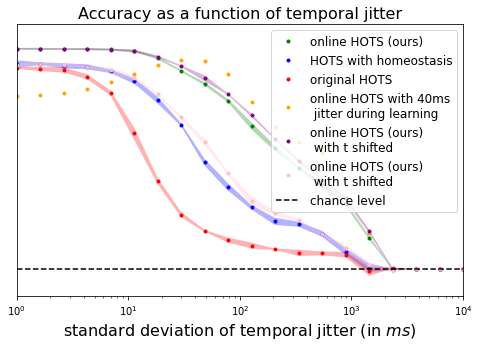

In [21]:
fitting = False
logscale = True

f_name = f'../Records/EXP_03_NMNIST/2021-03-29_LR_results_jitter_homhots_[4, 8, 16]_60000_1000_1_None_logscale.pkl'
with open(f_name, 'rb') as file:
    results_t, results_t_last, jit_t = pickle.load(file)
    
results_t = np.delete(results_t, [5,6,7,8,9], 0)
fig_t, ax_t = plt.subplots(1,1,figsize=(8,5))
param_T = [0.85, 2.5, 5, 0.1]
label = 'online HOTS (ours)'
n_epoch = 33
fig_t, ax_t, semisat_t = plotjitter(fig_t, ax_t, jit_t/1e3, results_t, param = param_T, color='green', label=label, n_epo=n_epoch, fitting = fitting, logscale=logscale)
if fitting:
    print(f'semi saturation level for {label}: {np.round(10**semisat_t,2)} ms')

f_name = f'../Records/EXP_03_NMNIST/2021-03-29_histo_results_jitter_homhots_[4, 8, 16]_60000_1000_1_None_logscale.pkl'
with open(f_name, 'rb') as file:
    score_t12, jit_t = pickle.load(file)

score_t12 = np.delete(score_t12, [5,6,7,8,9], 0)
label = 'HOTS with homeostasis'
param_T = [0.8, 1.7, 5, 0.1]
fig_t, ax_t, semisat_t = plotjitter(fig_t, ax_t, jit_t/1e3, score_t12, param = param_T, color='blue', label=label, n_epo=n_epoch, fitting = fitting, logscale=logscale)
if fitting:
    print(f'semi saturation level for {label}: {np.round(10**semisat_t,2)} ms')

f_name = f'../Records/EXP_03_NMNIST/2021-03-29_histo_results_jitter_hots_[4, 8, 16]_60000_1000_1_None_logscale.pkl'
with open(f_name, 'rb') as file:
    score_t12, jit_t = pickle.load(file)

score_t12 = np.delete(score_t12, [0,7,8,9], 0)
label = 'original HOTS'
param_T = [0.8, 1.3, 5, 0.1]
fig_t, ax_t, semisat_t = plotjitter(fig_t, ax_t, jit_t/1e3, score_t12, param = param_T, color='red', label=label, n_epo=n_epoch, fitting = fitting, logscale=logscale)
if fitting:
    print(f'semi saturation level for {label}: {np.round(10**semisat_t,2)} ms')

f_name = f'../Records/EXP_03_NMNIST/2021-05-27_LR_results_jitter_homhots_6000_1000_1_None_initjitter40ms.pkl'
with open(f_name, 'rb') as file:
    results_t, results_t_last, jit_t = pickle.load(file)
label = 'online HOTS with 40ms\n jitter during learning'
param_T = [0.8, 1.7, 5, 0.1]
fig_t, ax_t, semisat_t = plotjitter(fig_t, ax_t, jit_t/1e3, results_t, param = param_T, color='orange', label=label, n_epo=n_epoch, fitting = fitting, logscale = logscale)
if fitting:
    print(f'semi saturation level for {label}: {np.round(10**semisat_t,2)} ms')
    
f_name = f'../Records/EXP_03_NMNIST/2021-03-29_LR_results_jitter_homhots_[4, 8, 16]_60000_1000_1_None_logscale_shifted.pkl'
with open(f_name, 'rb') as file:
    results_t, results_t_last, jit_t = pickle.load(file)
    
results_t = np.delete(results_t, [5,6,7,8,9], 0)
param_T = [0.85, 2.5, 5, 0.1]
label = 'online HOTS (ours) \n with t shifted'
n_epoch = 33
fig_t, ax_t, semisat_t = plotjitter(fig_t, ax_t, jit_t/1e3, results_t, param = param_T, color='purple', label=label, n_epo=n_epoch, fitting = fitting, logscale=logscale)
if fitting:
    print(f'semi saturation level for {label}: {np.round(10**semisat_t,2)} ms')
    
f_name = f'../Records/EXP_03_NMNIST/2021-03-29_histo_results_jitter_homhots_[4, 8, 16]_60000_1000_1_None_logscale_shifted.pkl'
with open(f_name, 'rb') as file:
    score_t12, jit_t = pickle.load(file)
    
results_t = np.delete(score_t12, [5,6,7,8,9], 0)
param_T = [0.85, 2.5, 5, 0.1]
label = 'online HOTS (ours) \n with t shifted'
n_epoch = 33
fig_t, ax_t, semisat_t = plotjitter(fig_t, ax_t, jit_t/1e3, results_t, param = param_T, color='pink', label=label, n_epo=n_epoch, fitting = fitting, logscale=logscale)
if fitting:
    print(f'semi saturation level for {label}: {np.round(10**semisat_t,2)} ms')

chance_t = np.ones([len(jit_t)])*10
ax_t.plot(jit_t/1e3,chance_t, 'k--', label='chance level')
ax_t.axis([1,max(jit_t/1e3),0,100]);
ax_t.set_xlabel('standard deviation of temporal jitter (in $ms$)', fontsize=16);
#ax_t.set_ylabel('accuracy (in %)', fontsize=16);
ax_t.set_yticks([])
ax_t.set_title('Accuracy as a function of temporal jitter', fontsize=16);
ax_t.legend(fontsize=12);